```
- Classifier       - takes in text OR image                           outputs a number (category).
                        newsgroups OR MNIST
- Regressor        - takes in numbers                                 outputs numbers.
                        house price
- AutoEncoder      - takes in images                                  outputs images.
                        MNIST
- LLM/Transformer  - takes in text                                    outputs text.
                        Llama
- ???              - takes in text AND numbers AND images AND audio   outputs text AND numbers AND images AND audio.
                        Gato
```

How would you do that?

We've used CountVectorizer and TfidfVectorizer to turn text into vector embeddings.

We've used ResNet to turn images into vector embeddings.

We haven't used anything to combine text and images into a single embedding.

In [1]:
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
import torch
import torch.nn as nn
from torch import tensor
import transformers
from transformers import GPT2Config
from functools import partial

from mugato.data import ok_vqa, four_rooms
from mugato.tokenizer import Tokenizer
from mugato.utils import image_transform, as_tensor

random.seed(42)

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.clone().detach().numpy()
    else:
        return x

def plot_embedding(xs, ys, zs, max_x=10, max_y=10, max_z=10, colors=None):
    if not isinstance(xs, list):
        xs, ys, zs = [xs], [ys], [zs]
    # Create a new figure and add a 3D subplot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if colors is None:
        colors = ['red'] * len(xs)
    
    # Plot the points
    with torch.no_grad():
        ax.scatter(to_numpy(xs), to_numpy(ys), to_numpy(zs), color=colors, marker='o')
    
    # Set axes limits
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_zlim(-7, 7)
    
    # Label the axes
    ax.set_xlabel('X ("A"-ness)')
    ax.set_ylabel('Y ("vowely"-ness)')
    ax.set_zlabel('Z ("lettery"-ness)')
    
    # Display the plot
    plt.show()

def imshow(image):
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1, 2, 0))
    plt.show()

vqa_dataset = ok_vqa.initialize()
sample_index = 10
sample = vqa_dataset['train'][sample_index]
image = as_tensor(sample['image']) / 255

four_rooms_dataset = four_rooms.initialize()

tiktoken_tokenizer = tiktoken.get_encoding("r50k_base")
tokenizer = Tokenizer(tiktoken_tokenizer)
vqa_dataset = ok_vqa.initialize()
vqa_dataloader = ok_vqa.create_dataloader(tokenizer, batch_size=4)
dlit = iter(vqa_dataloader);
next(dlit); next(dlit);
batch = next(dlit)

%matplotlib widget

# Embeddings

Are these two phrases similar?

In [2]:
word_1 = "big blue ocean"
word_2 = "little green frog"

<details>

It depends on what conceptual idea you compare them.

They are both things you might see in a painting of a landscape.

One you can live in, the other you can't.

They both have the same number of letters

One has an 'h', the other doesn't.

</details>

In [3]:
# Helper functions to get "features" of our phrases.
def count_vowels(text):
    return len([c for c in text if c in 'aeiouy']) / 2

def count_letter(letter, text):
    return len([c for c in text if c == letter]) / 3

count_L = partial(count_letter, 'l')

In [4]:
def example_embedding_1(text):
    """
    Embeds the text in a 3-dimensional space.
    
    [            x,                y,              z]

    [number of 'l', number of vowels, length of text]

    """
    x = count_L(text)      # number of "l"s
    y = count_vowels(text) # number of vowels
    z = len(text) / 3      # number of letters / 3
    return x, y, z

In [5]:
example_embedding_1("big blue ocean"), example_embedding_1("little green frog")

((0.3333333333333333, 3.0, 4.666666666666667),
 (0.6666666666666666, 2.5, 5.666666666666667))

Because our embedding space is 3-dimensions, we can visualize where these phrases land in embedding space.

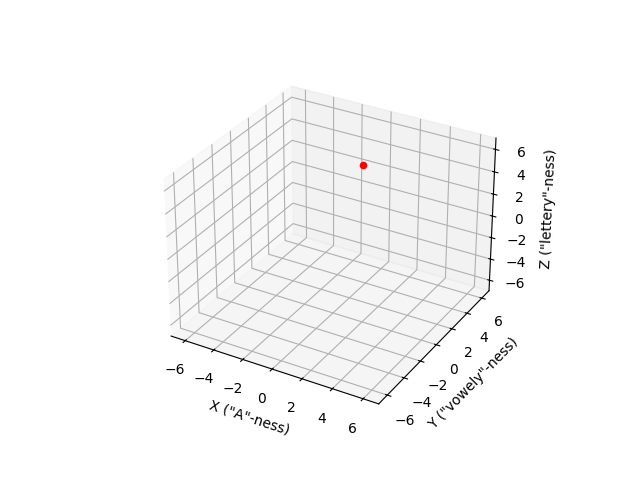

In [6]:
plot_embedding(*example_embedding_1('big blue ocean'))

This next cell, I just want to show you what it looks like to plot multiple things in the same 3d space.

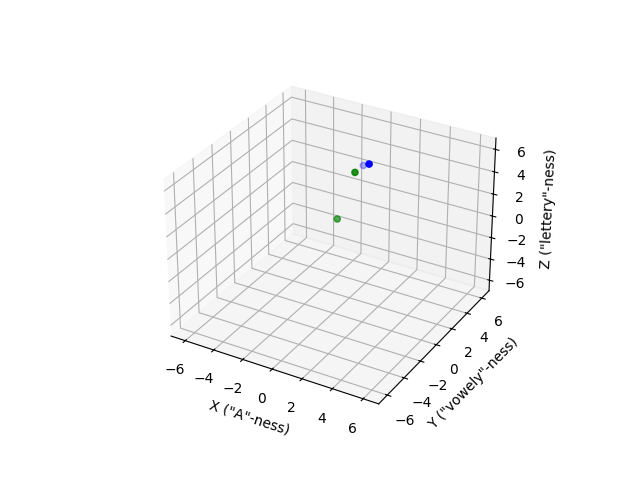

In [7]:
plot_embedding(*zip(
    example_embedding_1('big blue ocean'),
    example_embedding_1('little blue bird'),
    example_embedding_1('big green hulk'),
    example_embedding_1('frog'),
), colors=[
    "blue",
    "blue",
    "green",
    "green",
])

We've been using this embedding function, `example_embedding_1`, which takes a text, and returns an embedding.

In [8]:
def example_embedding_1(text):
    x = count_L(text)      # number of "l"s
    y = count_vowels(text) # number of vowels
    z = len(text) / 3      # number of letters / 3
    return x, y, z


How do they really do it, in the real world?

- CountVectorizer
- TfidfVectorizer
- Word2Vec
- ...

## "Embedding Layers" (nn.Embedding)

An ***"embedding layer"*** is a thing that ***takes something*** (a token, a document, etc...) ***and returns an a list of numbers*** (an embedding).

In [9]:
model = transformers.AutoModel.from_config(GPT2Config())
model  # First layer: Embedding(50257, 768)  <- What is the 50257? What is the 768?

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

Move this down maybe?

In [10]:
model = transformers.AutoModel.from_config(GPT2Config(vocab_size=50257, n_embd=3, n_head=1))
model

GPT2Model(
  (wte): Embedding(50257, 3)
  (wpe): Embedding(1024, 3)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=9, nx=3)
        (c_proj): Conv1D(nf=3, nx=3)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=12, nx=3)
        (c_proj): Conv1D(nf=3, nx=12)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
)

We can make our own embedding layer. (Remember the Gato paper, we want to take text, images, actions, button presses, etc... and turn them into embeddings.)

- Again, what is an "embedding layer"?
- How would you make a text embedding layer?

In [11]:
vocabulary = [
    'big',
    'little',
    'blue',
    'green',
    'ocean',
    'bird',
    'frog',
    'hulk',
]

In [12]:
# Create a dictionary where each word (token) is the key, and each value is 3 random numbers.
embedding_layer = {}
for i, word in enumerate(vocabulary):
    embedding_layer[word] = torch.randn(3)  # Example: embedding_layer['big'] = [0.12, 1.5, -0.3]

In [13]:
embedding_layer['big']

tensor([ 0.9587, -0.1270,  0.0289])

In [14]:
tiktoken_tokenizer = tiktoken.get_encoding("r50k_base")
tiktoken_tokenizer.encode('big blue ocean')

[14261, 4171, 9151]

A new plot, like the one above, but instead of defining the meaning/concept of each dimension (numer of l's, number of vowels, length of text), we are initializing the values of each dimension randomly.

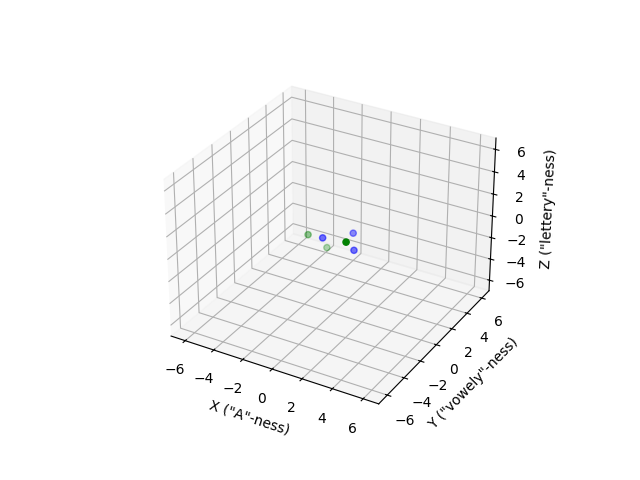

In [15]:
plot_embedding(*zip(
    embedding_layer['big'],
    embedding_layer['green'],
    embedding_layer['hulk'],
    embedding_layer['little'],
    embedding_layer['blue'],
    embedding_layer['bird'],
), colors=[
    'green',
    'green',
    'green',
    'blue',
    'blue',
    'blue',
])

A brief aside:

We can "combine" embeddings to create new embeddings.

- How would you combine the embeddings of "little" and "blue"?

In [16]:
def combine_embeddings(embedding_1, embedding_2):
    return (embedding_1 + embedding_2) / 2


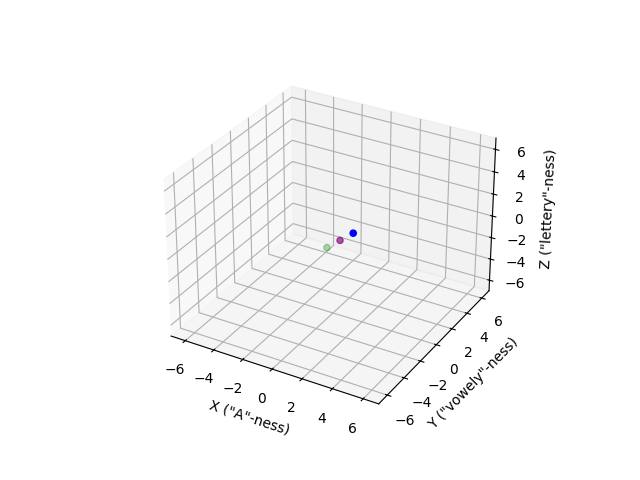

In [17]:
plot_embedding(*zip(
    embedding_layer['blue'],
    embedding_layer['green'],    
    combine_embeddings(embedding_layer['blue'], embedding_layer['green']),
), colors=[
    'blue',
    'green',
    'purple',
])

Every new state of the art machine learning algorithm (Transformer, ResNet, etc...) is basically just a new clever way to combine embeddings.

But even something as simple as taking the average works. It just doesn't work well.

- In typical English text, do you expect the word "little" to be near the word "frog"?

Do you expect those two words to be close to each other in the embedding space?

# Images

What about images?

How would you embed an image into the same 3-dimensional embedding space that we've been using above?

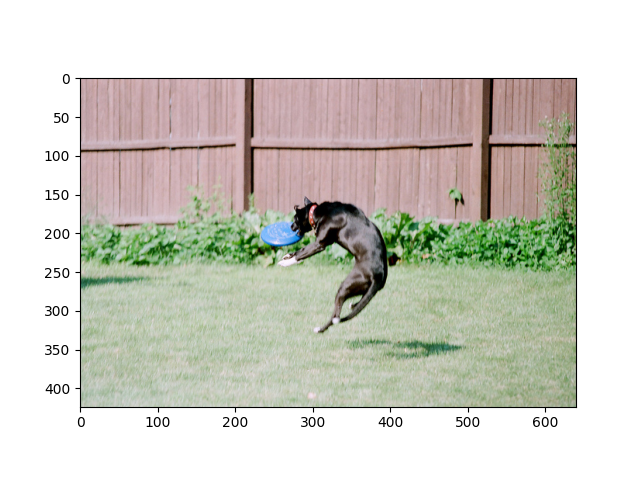

In [18]:
imshow(image)

- Is an image a token?

- What's an "Embedding Layer"?

In [19]:
# Is this an "embedding layer"?
def example_image_embedding(image):
    x = image[0].mean() * 5  # Red channel
    y = image[1].mean() * 5  # Green channel
    z = image[2].mean() * 5  # Blue channel
    return torch.tensor([x, y, z])

In [20]:
example_image_embedding(image)

tensor([3.3682, 3.3384, 2.9908])

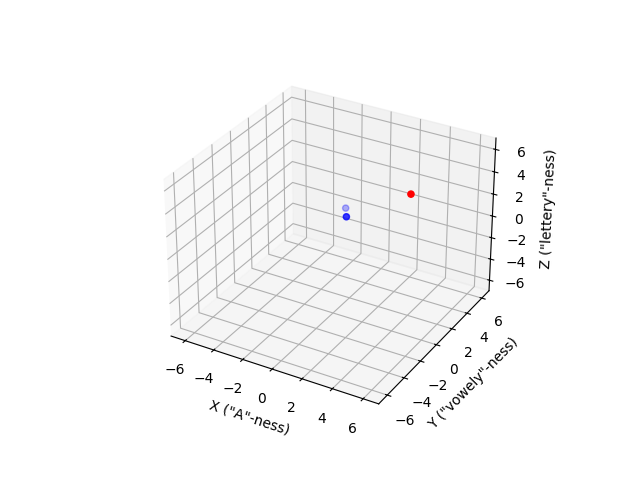

In [21]:
plot_embedding(*zip(
    example_embedding_1('blue'),
    example_embedding_1('ocean'),
    example_image_embedding(image),
), colors=[
    'blue',
    'blue',
    'red',
])

# "Discrete" button presses

How would you embed an Atari button press (up, down, left, right)?

In [22]:
FORWARD = tensor(0)
BACKWARD = tensor(1)
LEFT = tensor(2)
RIGHT = tensor(3)
FORWARD, BACKWARD, LEFT, RIGHT

(tensor(0), tensor(1), tensor(2), tensor(3))

In [23]:
# Effectively the same thing as:
# atari_embedding = {
#     FORWARD:    torch.randn(3),
#     BACKWARD:  torch.randn(3),
#     LEFT:  torch.randn(3),
#     RIGHT: torch.randn(3),
# }
atari_embedding = nn.Embedding(4, 3)

In [24]:
atari_embedding(FORWARD)

tensor([-1.8854, -0.1196, -0.6759], grad_fn=<EmbeddingBackward0>)

Ok.

Now we can embed text, images, and discrete values like button presses.

How do we embed continuous values?

# Continuous robotic arm movements

How would you encode the angular position of a robotic arm?

The position could be any floating point number between 0 and 360.

`nn.Embedding(..., 3)`?

There's an infinite number of possible positions.

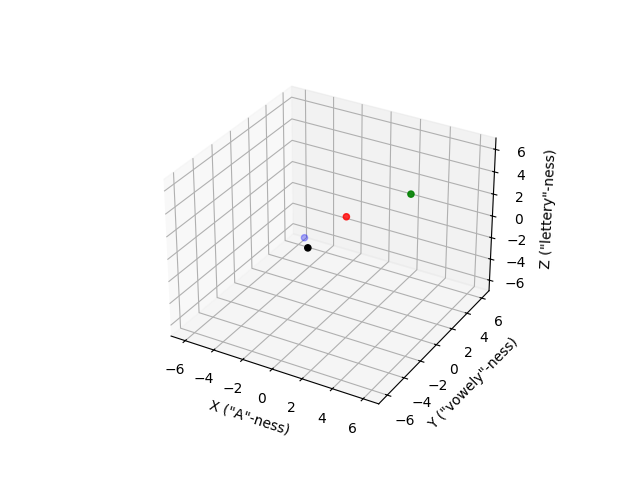

In [25]:
def tokenize_position(position):
    if position >= 0 and position < 90:
        return tensor(0)
    elif position >= 90 and position < 180:
        return tensor(1)
    elif position >= 180 and position < 270:
        return tensor(2)
    elif position >= 270 and position <= 360:
        return tensor(3)

continuous_embedding = nn.Embedding(4, 3)
plot_embedding(*zip(
    example_embedding_1('blue'),
    example_image_embedding(image),
    atari_embedding(FORWARD),
    continuous_embedding(tokenize_position(45.8992)),
), colors=[
    'red',
    'green',
    'blue',
    'black',
])


# Training

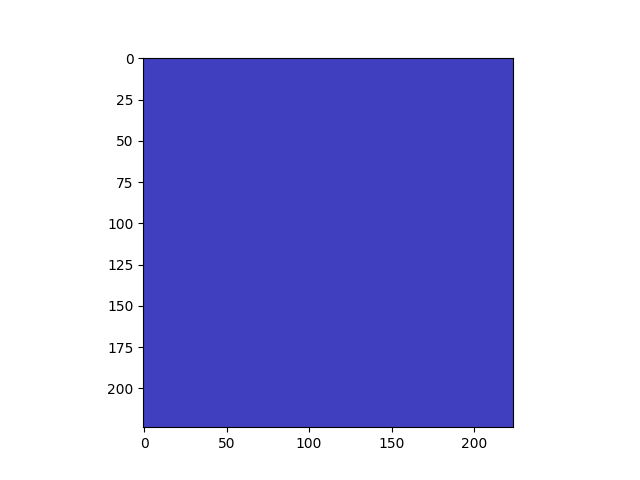

In [26]:
BLUE_IMAGE = torch.ones(3, 224, 224)
BLUE_IMAGE[0, :, :] *= 0.25
BLUE_IMAGE[1, :, :] *= 0.25
BLUE_IMAGE[2, :, :] *= 0.75
BLUE_IMAGE = nn.Parameter(BLUE_IMAGE, requires_grad=True)
GREEN_IMAGE = torch.ones(3, 224, 224)
GREEN_IMAGE[0, :, :] *= 0.25
GREEN_IMAGE[1, :, :] *= 0.75
GREEN_IMAGE[2, :, :] *= 0.25
GREEN_IMAGE = nn.Parameter(GREEN_IMAGE, requires_grad=True)
imshow(BLUE_IMAGE.detach())

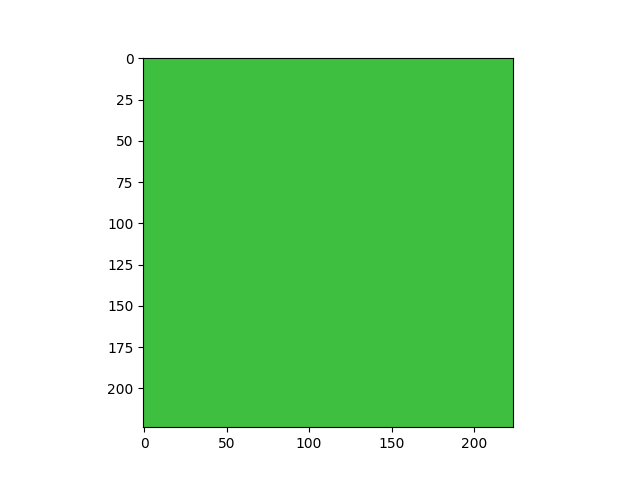

In [27]:
imshow(GREEN_IMAGE.detach())

In [81]:
#           X                            Y
train_dataset = [
    # Good things, go forward to little green frogs and little blue birds
    [['little', 'green', 'frog'],                  FORWARD],
    [['little', GREEN_IMAGE, 'frog'],              FORWARD],

    # Bad things, go backward to big green hulks and big blue oceans
    [['big', 'blue', 'ocean', BLUE_IMAGE],       BACKWARD],
    [['blue', 'big', BLUE_IMAGE, 'ocean'],       BACKWARD],
]

In [100]:
atari_decoding = {
    0: 'FORWARD',
    1: 'BACKWARD',
    2: 'LEFT',
    3: 'RIGHT',
}

for key in embedding_layer:
    if not isinstance(embedding_layer[key], nn.Parameter):
        embedding_layer[key] = nn.Parameter(embedding_layer[key], requires_grad=True)

def embed(sample):
    embeddings = None
    for token in sample:
        if isinstance(token, str):
            if embeddings is None:
                embeddings = embedding_layer[token].unsqueeze(0)
            else:
                embeddings = torch.cat([embeddings, embedding_layer[token].unsqueeze(0)])
        elif isinstance(token, torch.Tensor):
            if embeddings is None:
                if token.shape == (3, 224, 224):
                    embeddings = example_image_embedding(token).unsqueeze(0)
                else:
                    embeddings = atari_embedding(token).unsqueeze(0)
            else:
                if token.shape == (3, 224, 224):
                    embeddings = torch.cat([embeddings, example_image_embedding(token).unsqueeze(0)])
                else:
                    embeddings = torch.cat([embeddings, atari_embedding(token).unsqueeze(0)])
        else: 
            raise ValueError(f"Unknown token type: {type(token)}")
    return embeddings

def decode(token):
    if token >= len(vocabulary):
        return atari_decoding[(token - len(embedding_layer)).item()]
    else:
        return vocabulary[token]

def encode(target):
    if isinstance(target, str):
        return tensor(vocab_index_of(target))
    else:
        return target + len(embedding_layer)

def combine_all_embeddings(embeddings):
    return torch.mean(embeddings, dim=0)

def vocab_index_of(token):
    return next((i for i, t in enumerate(embedding_layer) if t == token), -1)

def loss_fn(prediction, target):
    if isinstance(target, str):
        target = tensor(vocab_index_of(target))
    else:
        target = target + len(embedding_layer)
    return nn.functional.cross_entropy(prediction, target)

num_out = (
    len(embedding_layer)   # number of words in our vocabulary
    + len(atari_embedding.weight) # number of button presses
)

In [101]:

model = nn.Sequential(
    nn.Linear(3, 2),
    nn.Sigmoid(),
    nn.Linear(2, num_out),
)
optimizer = torch.optim.AdamW([
    {'params': model.parameters()},
    {'params': embedding_layer.values()},
    {'params': [BLUE_IMAGE, GREEN_IMAGE]},
    {'params': atari_embedding.parameters()}
    ], lr=0.001)


In [102]:
sample, target = ['little', GREEN_IMAGE, 'frog'], FORWARD  # Expect "little" and GREEN IMAGE to be close to something like "frog" or "green" or FORWARD. (Little green frogs are good.)

# Forward to make a prediction.
embeddings = combine_all_embeddings(embed(sample))

predictions = model(embeddings)
predicted_token = decode(predictions.argmax())

print(f'Expected: {decode(target + len(vocabulary))}\nGot: {predicted_token}\nWith confidence {predictions.max():.3f}')

Expected: FORWARD
Got: RIGHT
With confidence 0.855


In [124]:
sample, target = ['little', GREEN_IMAGE, 'frog'], FORWARD
embeddings = combine_all_embeddings(embed(sample))
prediction = model(embeddings)
loss = nn.functional.cross_entropy(prediction, encode(target))
loss.backward()
optimizer.step()
optimizer.zero_grad()


In [125]:
sample, target = ['little', GREEN_IMAGE, 'frog'], FORWARD
embeddings = combine_all_embeddings(embed(sample))
predictions = model(embeddings)
predicted_token = decode(predictions.argmax())

print(f'Expected: {target}\nGot: {predicted_token}\nWith confidence {predictions.max():.3f}')

Expected: 0
Got: FORWARD
With confidence 2.553


In [114]:
embedding_layer['blue'], model(embeddings), list(model.parameters())[0], model(embeddings).max(), model(embeddings).argmax()

(Parameter containing:
 tensor([-0.4344,  2.5767,  0.2987], requires_grad=True),
 tensor([-0.2577,  0.0312, -0.0127,  0.0780, -0.2294,  0.7028, -0.1414, -1.0636,
          0.4836, -0.7820,  0.0589,  0.8395], grad_fn=<ViewBackward0>),
 Parameter containing:
 tensor([[ 0.3099,  0.1752,  0.0900],
         [-0.5777,  0.2964,  0.0629]], requires_grad=True),
 tensor(0.8395, grad_fn=<MaxBackward1>),
 tensor(11))

In [115]:
sample, target = train_dataset[0]
embeddings = combine_all_embeddings(embed(sample))
prediction = model(embeddings)
optimizer.zero_grad()
loss = nn.functional.cross_entropy(prediction, encode(target))
loss.backward()
optimizer.step()
target, tensor(vocab_index_of(target)), vocabulary[4], prediction, loss

(tensor(0),
 tensor(-1),
 'ocean',
 tensor([-0.3225, -0.0082, -0.1288,  0.1965, -0.2105,  0.6336, -0.0421, -0.9935,
          0.4131, -0.7111,  0.1434,  0.7925], grad_fn=<ViewBackward0>),
 tensor(2.1673, grad_fn=<NllLossBackward0>))

In [116]:
target

tensor(0)

In [117]:
embedding_layer['blue'], model(embeddings), list(model.parameters())[0], model(embeddings).max(), model(embeddings).argmax()

(Parameter containing:
 tensor([-0.4344,  2.5767,  0.2987], requires_grad=True),
 tensor([-0.3243, -0.0093, -0.1298,  0.1938, -0.2123,  0.6320, -0.0440, -0.9955,
          0.4154, -0.7137,  0.1415,  0.7907], grad_fn=<ViewBackward0>),
 Parameter containing:
 tensor([[ 0.3108,  0.1762,  0.0889],
         [-0.5786,  0.2955,  0.0639]], requires_grad=True),
 tensor(0.7907, grad_fn=<MaxBackward1>),
 tensor(11))

In [118]:
import math; -math.log(1/12)

2.4849066497880004

In [119]:
atari_embedding(FORWARD)

tensor([-4.5277,  1.6969, -1.1893], grad_fn=<EmbeddingBackward0>)

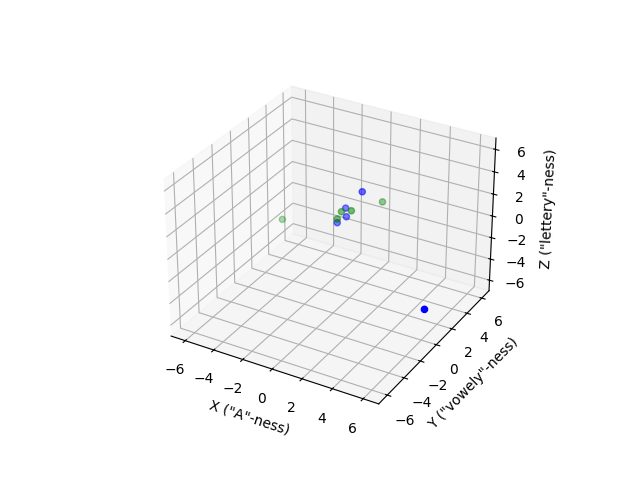

In [126]:
plot_embedding(*zip(
    example_embedding_1('big'),
    example_embedding_1('blue'),
    example_embedding_1('ocean'),
    example_image_embedding(BLUE_IMAGE),
    atari_embedding(BACKWARD),
    example_embedding_1('little'),
    example_embedding_1('green'),
    example_embedding_1('frog'),
    example_image_embedding(GREEN_IMAGE),
    atari_embedding(FORWARD),
), colors=[
    'blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'green',
    'green',
    'green',
    'green',
    'green',
])


In [127]:
losses = []

In [128]:
from tqdm.notebook import tqdm

In [129]:

for _ in tqdm(range(1000)):
    for sample, target in train_dataset:
        embeddings = combine_all_embeddings(embed(sample))
        probabilities = model(embeddings)
        loss = loss_fn(probabilities, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

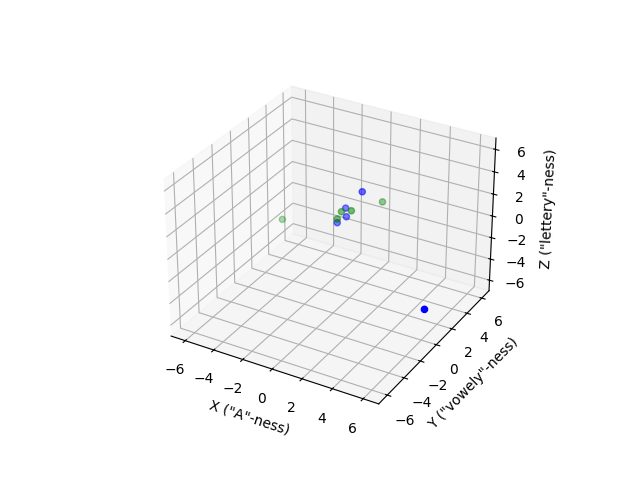

In [130]:
plot_embedding(*zip(
    example_embedding_1('big'),
    example_embedding_1('blue'),
    example_embedding_1('ocean'),
    example_image_embedding(BLUE_IMAGE),
    atari_embedding(BACKWARD),
    example_embedding_1('little'),
    example_embedding_1('green'),
    example_embedding_1('frog'),
    example_image_embedding(GREEN_IMAGE),
    atari_embedding(FORWARD),
), colors=[
    'blue',
    'blue',
    'blue',
    'blue',
    'blue',
    'green',
    'green',
    'green',
    'green',
    'green',
])


In [131]:
atari_embedding(BACKWARD)

tensor([ 8.8469, -5.2992,  0.8675], grad_fn=<EmbeddingBackward0>)

/var/folders/10/h8rw5f1n0_v4s1l5db9hr5m00000gn/T/ipykernel_67462/3239998452.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


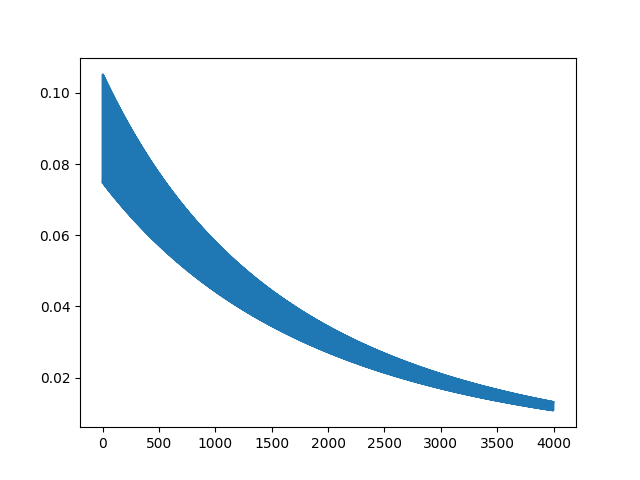

In [132]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(losses)
# Display the plot
plt.show()

In [53]:
for sample, target in train_dataset:
    embeddings = embed(sample)
    

In [54]:
tiktoken_tokenizer.encode('cloudy sky')

[17721, 88, 6766]

In [55]:
print(f'{"token":>10}: {"text":>10}')

for token in tiktoken_tokenizer.encode("cloudy sky"):
    decoded = tiktoken_tokenizer.decode([token])
    print(f'{token:>10}: {decoded:>10}')

     token:       text
     17721:      cloud
        88:          y
      6766:        sky


In [56]:
print(f'{"token":>10}: {"text":>10}')

for token in tiktoken_tokenizer.encode("Hello, abcDEF world!"):
    decoded = tiktoken_tokenizer.decode([token])
    print(f'{token:>10}: {decoded:>10}')

     token:       text
     15496:      Hello
        11:          ,
       450:         ab
        66:          c
     32988:        DEF
       995:      world
         0:          !


In [57]:
tokens = spaces_tokenizer('a lake')
embeddings = [
    example_embedding_2(token) for token in tokens
]
embeddings

NameError: name 'spaces_tokenizer' is not defined

## Tokenizing images

#### Visual question answering.

In [509]:
sample_index = 10
sample = vqa_dataset['train'][sample_index]

In [510]:
sample.keys()

dict_keys(['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'])

We want to encode this sample as:

```
[question...,  image...,  answer...   ]
     ^           ^           ^
     |           |           |
[  given this prefix   ,  predict this]
```

#### Robotic movement and control.

In [511]:
robotics_sample = four_rooms_dataset['train'][0]

In [512]:
robotics_sample.observations.keys()

dict_keys(['direction', 'image', 'mission'])

In [513]:
robotics_sample.actions

array([1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

We want to encode this sample as:

```
[mission..., image..., direction...,   action...  ]
   ^           ^            ^             ^
   |           |            |             |
[      given this prefix...        , predict this ]
```

In [514]:
sample['question']

'Which breed of dog it this?'

In [515]:
spaces_tokenizer(sample['question'])

['Which', 'breed', 'of', 'dog', 'it', 'this?']

In [516]:
tokenizer.encode_text(sample['question'])

tensor([[13828],
        [15939],
        [  286],
        [ 3290],
        [  340],
        [  428],
        [   30]])

In [517]:
sample['answers'][0]

{'answer': 'doberman',
 'raw_answer': 'doberman',
 'answer_confidence': 'yes',
 'answer_id': 1}

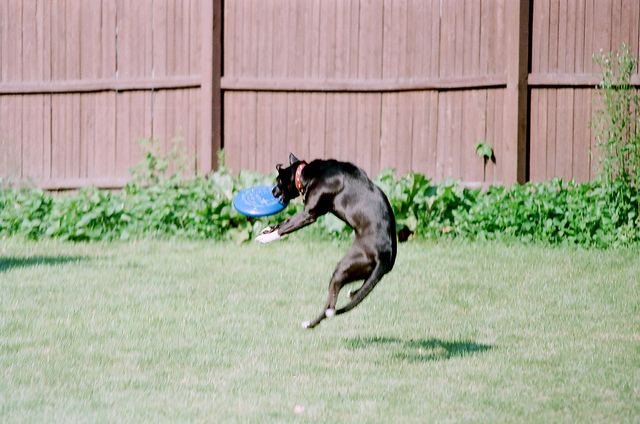

In [518]:
sample['image']

In [519]:
inputs, labels, attention_mask = batch

In [520]:
inputs['question'][2]

tensor([[[13828],
         [15939],
         [  286],
         [ 3290],
         [  340],
         [  428],
         [   30],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0],
         [    0]]])

In [521]:
tokenizer.decode_text(inputs['question'][2].squeeze())

'Which breed of dog it this?!!!!!!!!!!!!!!'

In [522]:
from torch import tensor

In [558]:
vocab_to_token = {
    'pond': 0,
    'ocean': 1,
    'frog': 2,
    'hulk': 3,
    'blue': 4,
    'green': 5,
    'big': 6,
    'little': 7,
}
vocab_size = len(vocab_to_token)

token_to_vocab = {
    0: 'pond',
    1: 'ocean',
    2: 'frog',
    3: 'hulk',
    4: 'blue',
    5: 'green',
    6: 'big',
    7: 'little',
}

embedding_layer = nn.Embedding(8, 3)
model = nn.Sequential(
    nn.Linear(3, 16),
    nn.Linear(16, vocab_size),
)

In [566]:
embedding = embedding_layer(tensor([vocab_to_token[token] for token in spaces_tokenizer('little blue pond')]))

In [567]:
embedding

tensor([[ 0.7817, -0.0323,  1.0107],
        [ 0.6176,  1.3297, -1.4652],
        [ 0.0025, -0.4366,  0.2195]], grad_fn=<EmbeddingBackward0>)

In [560]:
model(embedding)

tensor([ 0.1127, -0.1456,  0.0904,  0.0028,  0.2014, -0.0725, -0.1473,  0.2115],
       grad_fn=<ViewBackward0>)

In [535]:
blue_image = torch.ones(3, 224, 224)
blue_image[0, :, :] *= 0.25
blue_image[1, :, :] *= 0.25
blue_image[2, :, :] *= 0.75
green_image = torch.ones(3, 224, 224)
green_image[0, :, :] *= 0.25
green_image[1, :, :] *= 0.75
green_image[2, :, :] *= 0.25

In [52]:
plot_embedding(*zip(
    embedding(tensor(vocab_to_token['pond'])),
    embedding(tensor(vocab_to_token['ocean'])),
    embedding(tensor(vocab_to_token['frog'])),
    embedding(tensor(vocab_to_token['hulk'])),
    embedding(tensor(vocab_to_token['blue'])),
    embedding(tensor(vocab_to_token['green'])),
    embedding(tensor(vocab_to_token['big'])),
    embedding(tensor(vocab_to_token['little'])),
    example_image_embedding(blue_image),
    example_image_embedding(green_image),
), colors=[
    'blue',
    'blue',
    'green',
    'green',
    'blue',
    'green',
    'red',
    'red',
    'lightblue',
    'lightgreen',
])

NameError: name 'embedding' is not defined

In [546]:
train_dataset = [
    'big',
    'blue',
    'ocean',
    'big blue',
    'big ocean',
    'blue ocean',
    'big blue ocean',

    'little',
    'green',
    'little green',
    'little frog',
    'green frog',
    'little green frog',

    'hulk',
    'big hulk',
    'green hulk',
    # 'big green hulk',

    'pond',
    'little pond',
    'blue pond',
    # 'little blue pond',
]

val_dataset = [
    'little blue pond',
    'big green hulk',
]

In [547]:
for sample in train_dataset:
    tokens = spaces_tokenizer(sample)
    print(tokens)

['big']
['blue']
['ocean']
['big', 'blue']
['big', 'ocean']
['blue', 'ocean']
['big', 'blue', 'ocean']
['little']
['green']
['little', 'green']
['little', 'frog']
['green', 'frog']
['little', 'green', 'frog']
['hulk']
['big', 'hulk']
['green', 'hulk']
['pond']
['little', 'pond']
['blue', 'pond']


In [548]:
for sample in train_dataset:
    tokens = [vocab_to_token[x] for x in spaces_tokenizer(sample)]
    print(tokens)

[6]
[4]
[1]
[6, 4]
[6, 1]
[4, 1]
[6, 4, 1]
[7]
[5]
[7, 5]
[7, 2]
[5, 2]
[7, 5, 2]
[3]
[6, 3]
[5, 3]
[0]
[7, 0]
[4, 0]


In [554]:
for sample in train_dataset:
    tokens = [vocab_to_token[x] for x in spaces_tokenizer(sample)]
    embeddings = embedding(tensor(tokens))
    print(embeddings)

tensor([[ 0.1449, -0.2296,  1.2026]], grad_fn=<EmbeddingBackward0>)
tensor([[-0.4847,  2.0607, -0.9564]], grad_fn=<EmbeddingBackward0>)
tensor([[-0.4159, -1.7179, -1.1812]], grad_fn=<EmbeddingBackward0>)
tensor([[ 0.1449, -0.2296,  1.2026],
        [-0.4847,  2.0607, -0.9564]], grad_fn=<EmbeddingBackward0>)
tensor([[ 0.1449, -0.2296,  1.2026],
        [-0.4159, -1.7179, -1.1812]], grad_fn=<EmbeddingBackward0>)
tensor([[-0.4847,  2.0607, -0.9564],
        [-0.4159, -1.7179, -1.1812]], grad_fn=<EmbeddingBackward0>)
tensor([[ 0.1449, -0.2296,  1.2026],
        [-0.4847,  2.0607, -0.9564],
        [-0.4159, -1.7179, -1.1812]], grad_fn=<EmbeddingBackward0>)
tensor([[-0.7505,  1.5675, -1.0184]], grad_fn=<EmbeddingBackward0>)
tensor([[1.8926, 0.2029, 1.2437]], grad_fn=<EmbeddingBackward0>)
tensor([[-0.7505,  1.5675, -1.0184],
        [ 1.8926,  0.2029,  1.2437]], grad_fn=<EmbeddingBackward0>)
tensor([[-0.7505,  1.5675, -1.0184],
        [ 0.2000, -0.5496,  0.8599]], grad_fn=<EmbeddingBackward